In [17]:
!pip install ultralytics==8.0.10
from IPython import display
display.clear_output()
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.10 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.0/78.2 GB disk)


In [8]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [9]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [10]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [5]:
!pip install supervision==0.1.0
from IPython import display
display.clear_output()
import supervision
print("supervision.__version__:",supervision.__version__)

supervision.__version__: 0.1.0


In [6]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [11]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

Load Pre-trained YOLO model

In [12]:
MODEL="yolov8x.pt"

In [18]:
from ultralytics import YOLO
model=YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:00<00:00, 183MB/s]

/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:361: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = 

In [19]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [2, 3, 5, 7]

In [20]:
from google.colab import files
import cv2
uploaded = files.upload()
Image = list(uploaded.keys())[0]


Saving traffic.jpg to traffic.jpg


Ultralytics YOLOv8.0.10 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
WARNING ⚠️ NMS time limit 0.550s exceeded


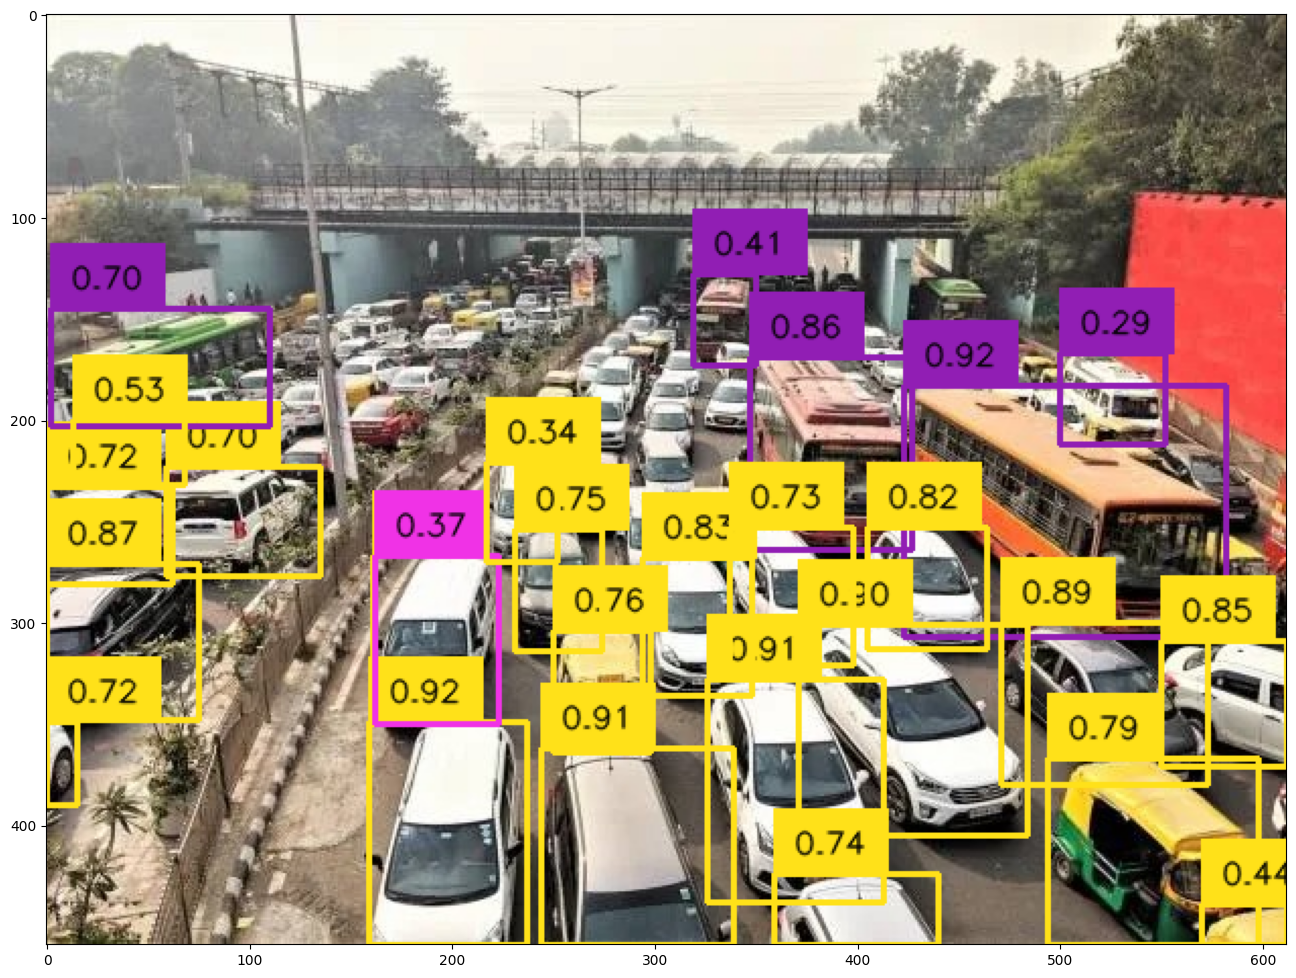

In [21]:

frame=cv2.imread(Image)
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=1, text_scale=0.5)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
box_coordinates = detections.xyxy
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

In [22]:
box_coordinates

array([[        159,         349,         237,         459],
       [        423,         183,         582,         307],
       [        326,         328,         413,         438],
       [        244,         362,         339,         459],
       [        371,         301,         484,         405],
       [        471,         300,         573,         380],
       [          0,         271,          75,         348],
       [        347,         169,         427,         264],
       [        550,         309,         612,         371],
       [        294,         268,         348,         336],
       [        405,         253,         464,         313],
       [        494,         367,         598,         459],
       [        250,         304,         298,         364],
       [        231,         254,         274,         314],
       [        359,         424,         440,         459],
       [        337,         253,         398,         321],
       [          0,    